In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
import re
import numpy as np
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense, Conv2DTranspose, Reshape, Multiply, \
    Embedding, Conv2D, Concatenate, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf
from datetime import datetime

In [2]:
keras.backend.clear_session()
z_dim = 100
num_class = 4
img_shape = (64, 64, 3)
batch_size = 9
epochs = 100
sample_interval = 10
path = '/home/neto/Documents/Linnaeus/train/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  image_size=(64, 64),
  batch_size=batch_size)

Found 4800 files belonging to 4 classes.


2021-11-01 16:39:01.251520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:39:01.256056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:39:01.256328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 16:39:01.257413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [5]:
def build_generator(z_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(256, 3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, 3, strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, 3, activation='tanh', padding='same'))

    return model


def build_cgan_generator(z_dim, num_classes):
    # latent input
    z = Input(shape=(z_dim,))
    # label input
    label = Input(shape=(1,), dtype='int32')
    # convert label to embedding
    label_embedding = Embedding(num_classes, z_dim)(label)

    label_embedding = Flatten()(label_embedding)
    # dot product two inputs
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    conditioned_img = generator(joined_representation)

    model = Model([z, label], conditioned_img)
    # save model blueprint to image
    plot_model(model, './cgan_generator.jpg', show_shapes=True, show_dtype=True)

    return model

In [6]:
def build_discriminator(img_shape):
    model = Sequential(name="discriminator")
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_shape[0], img_shape[1], img_shape[2] * 2)))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample 
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model


def build_cgan_discriminator(img_shape, num_classes):
    # image input
    img = Input(shape=img_shape)
    # label input
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)

    label_embedding = Flatten()(label_embedding)

    label_embedding = Reshape(img_shape)(label_embedding)
    # concatenate the image and label
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    classification = discriminator(concatenated)

    model = Model([img, label], classification)

    plot_model(model, './cgan_discriminator.jpg', show_shapes=True, show_dtype=True)

    return model

In [7]:
def build_cgan(generator, discriminator, z_dim):
    # Random noise vector z
    z = Input(shape=(z_dim,))

    # Image label
    label = Input(shape=(1,))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

In [8]:
def sample_images(image_grid_rows=2, image_grid_columns=2):
    
    class_names = train_ds.class_names

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    labels = np.arange(0, 4).reshape(-1, 1)

    gen_imgs = generator.predict([z, labels])

#     gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            img = (gen_imgs[cnt] + 1) / 2.0
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Class: ${class_names[labels[cnt][0]]}")
            cnt += 1

In [9]:
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    # returned the smoothed labels
    return labels

accuracies = []
losses = []
def train(epochs, batch_size, sample_interval, dataset):
#     (X_train, y_train) = img, labels

    bat_per_epo = len(dataset) # int(X_train.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    real = np.ones((batch_size, 1))  # np.asarray([.9] * batch_size)
    fake = np.zeros((batch_size, 1))  # np.asarray([.1] * batch_size)

    for epoch in range(epochs):
        g_loss = 0
        d_loss = []
        for j in range(bat_per_epo):
#             idx = np.random.randint(0, X_train.shape[0], batch_size)
            normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
            imgs, labels = next(iter(normalized_ds))
#             imgs, labels = X_train[idx], y_train[idx]

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict([z, labels])

            # Train the Discriminator
            d_loss_real = discriminator.train_on_batch([imgs, labels], real)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Generate a batch of noise vectors
            z = np.random.normal(0, 1, (batch_size, z_dim))

            # Get a batch of random labels
            labels = np.random.randint(0, num_class, batch_size).reshape(-1, 1)

            # Train the Generator
            g_loss = cgan.train_on_batch([z, labels], real)
            
        if (epoch + 1) % sample_interval == 0:
            # Output training progress
            print('>%d, %d/%d, [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch + 1, j + 1, bat_per_epo, d_loss[0], 100 * d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])

            # Output sample of generated images
            sample_images()

In [11]:
generator = build_cgan_generator(z_dim, num_class)

discriminator = build_cgan_discriminator(img_shape, num_class)
discriminator.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=4e-4),
                      metrics=['accuracy'])
discriminator.trainable = False

cgan = build_cgan(generator, discriminator, z_dim)
cgan.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=1e-4))

2021-11-01 16:39:13.803723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-01 16:39:14.379388: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


>10, 534/534, [D loss: 0.273756, acc.: 94.44%] [G loss: 3.284366]
>20, 534/534, [D loss: 0.220710, acc.: 100.00%] [G loss: 3.469388]
>30, 534/534, [D loss: 0.211814, acc.: 100.00%] [G loss: 2.800437]
>40, 534/534, [D loss: 0.221179, acc.: 100.00%] [G loss: 3.366792]
>50, 534/534, [D loss: 0.200427, acc.: 100.00%] [G loss: 3.182819]
>60, 534/534, [D loss: 0.226400, acc.: 100.00%] [G loss: 2.530187]
>70, 534/534, [D loss: 0.201603, acc.: 100.00%] [G loss: 2.664480]
>80, 534/534, [D loss: 0.202641, acc.: 100.00%] [G loss: 2.809536]
>90, 534/534, [D loss: 0.201274, acc.: 100.00%] [G loss: 2.572799]
>100, 534/534, [D loss: 0.216869, acc.: 100.00%] [G loss: 2.071448]


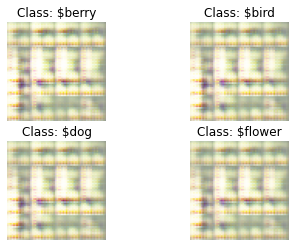

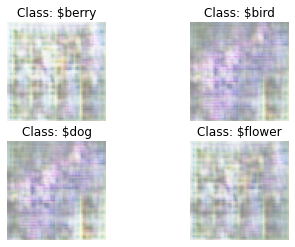

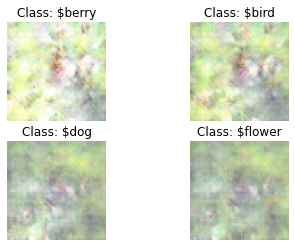

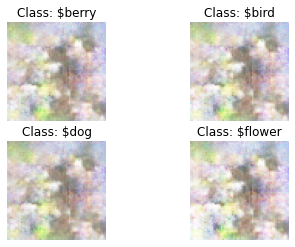

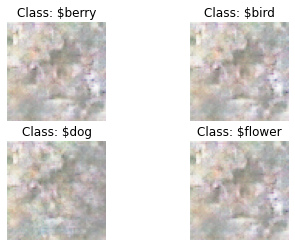

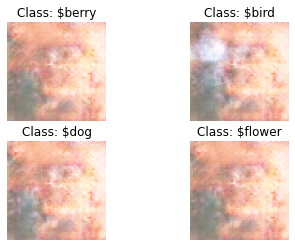

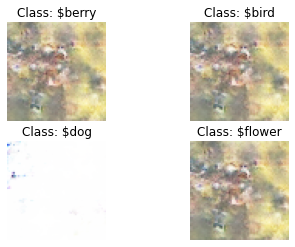

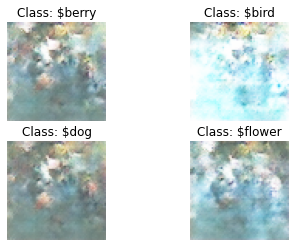

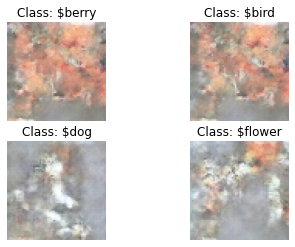

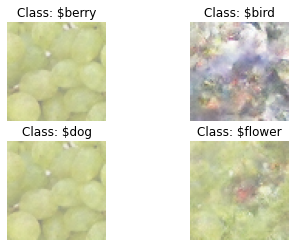

In [12]:
train(epochs, batch_size, sample_interval, train_ds)

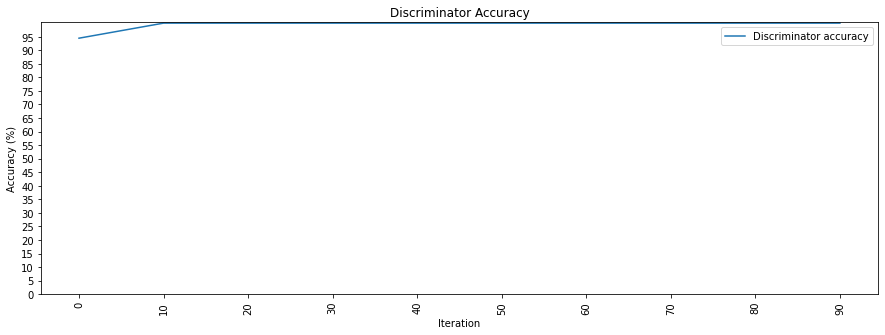

In [13]:
epoch = [x for x in range(0, epochs, 10)]

plt.figure(figsize=(15, 5))
plt.plot(epoch, accuracies, label="Discriminator accuracy")

plt.xticks(epoch, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

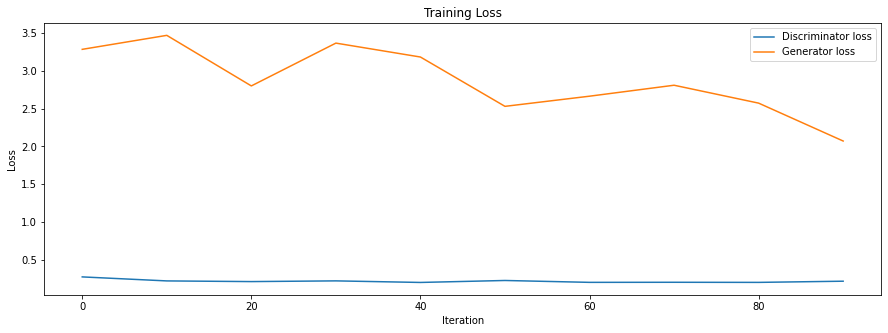

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(epoch, [x[0] for x in losses], label="Discriminator loss")
plt.plot(epoch, [x[1] for x in losses], label="Generator loss")

# plt.xticks(self.epoch, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [17]:
def build_discriminator(img_shape):
    model = Sequential(name="discriminator")
    # normal
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_shape[0], img_shape[1], img_shape[2] * 2)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample 
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model


def build_cgan_discriminator(img_shape, num_classes):
    # image input
    img = Input(shape=img_shape)
    # label input
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)

    label_embedding = Flatten()(label_embedding)

    label_embedding = Reshape(img_shape)(label_embedding)
    # concatenate the image and label
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = build_discriminator(img_shape)

    classification = discriminator(concatenated)

    model = Model([img, label], classification)

    plot_model(model, './cgan_discriminator.jpg', show_shapes=True, show_dtype=True)

    return model

>10, 534/534, [D loss: 0.210960, acc.: 100.00%] [G loss: 2.964539]
>20, 534/534, [D loss: 0.200698, acc.: 100.00%] [G loss: 3.065029]
>30, 534/534, [D loss: 0.204911, acc.: 100.00%] [G loss: 3.346672]
>40, 534/534, [D loss: 0.217801, acc.: 100.00%] [G loss: 2.740365]
>50, 534/534, [D loss: 0.201938, acc.: 100.00%] [G loss: 2.804820]
>60, 534/534, [D loss: 0.201172, acc.: 100.00%] [G loss: 2.932068]
>70, 534/534, [D loss: 0.204080, acc.: 100.00%] [G loss: 2.724626]
>80, 534/534, [D loss: 0.200356, acc.: 100.00%] [G loss: 2.932560]
>90, 534/534, [D loss: 0.204107, acc.: 100.00%] [G loss: 2.972751]
>100, 534/534, [D loss: 0.203244, acc.: 100.00%] [G loss: 3.105324]


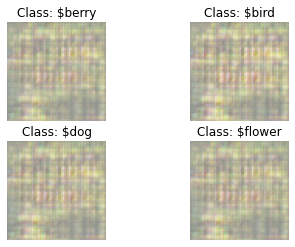

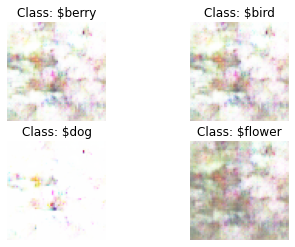

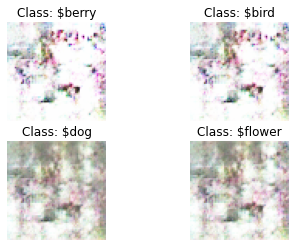

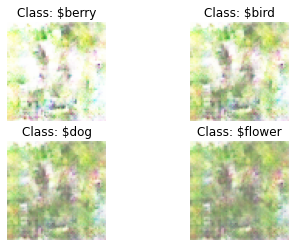

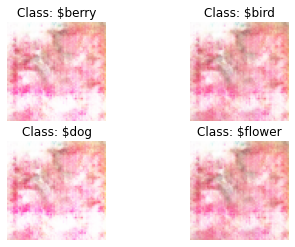

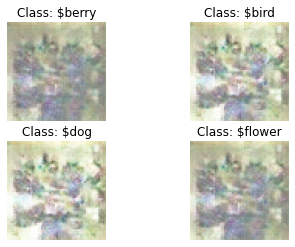

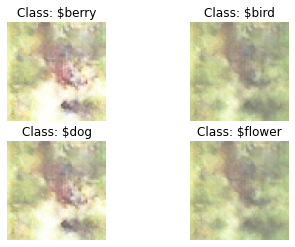

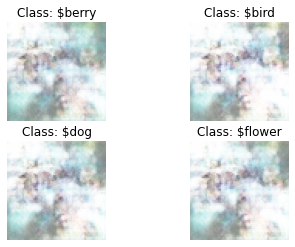

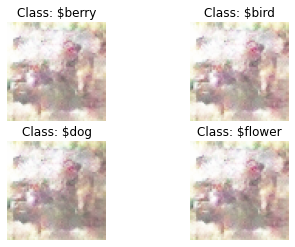

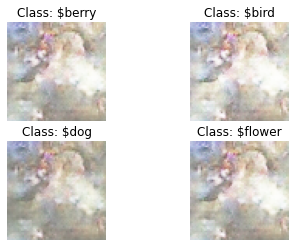

In [19]:
keras.backend.clear_session()
generator = build_cgan_generator(z_dim, num_class)

discriminator = build_cgan_discriminator(img_shape, num_class)
discriminator.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=4e-4),
                      metrics=['accuracy'])
discriminator.trainable = False

cgan = build_cgan(generator, discriminator, z_dim)
cgan.compile(loss=BinaryCrossentropy(label_smoothing=.1), optimizer=Adam(learning_rate=1e-4))

train(epochs, batch_size, sample_interval, train_ds)